In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Import  libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

1.Download data set

In [3]:
import pathlib
data_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=data_url, untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 4s 0us/step


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


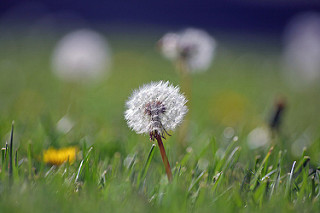

In [7]:
dandelion = list(data_dir.glob('dandelion/*'))
PIL.Image.open(str(dandelion[15]))

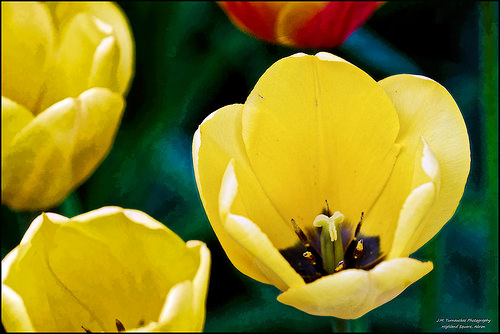

In [10]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[10]))

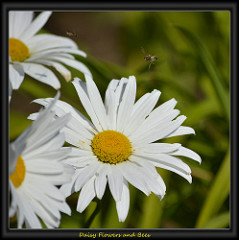

In [12]:
daisy = list(data_dir.glob('daisy/*'))
PIL.Image.open(str(daisy[35]))

2.Image augmentation

In [13]:
batch_size = 39
img_height = 180
img_width  = 180

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="training",
    seed=134,
    image_size =(img_height,img_width),
    batch_size = batch_size,
)

Found 3670 files belonging to 5 classes.
Using 3303 files for training.


In [15]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="validation",
    seed=134,
    image_size =(img_height,img_width),
    batch_size = batch_size,
)

Found 3670 files belonging to 5 classes.
Using 367 files for validation.


In [16]:
class_name = train_ds.class_names
print(class_name)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


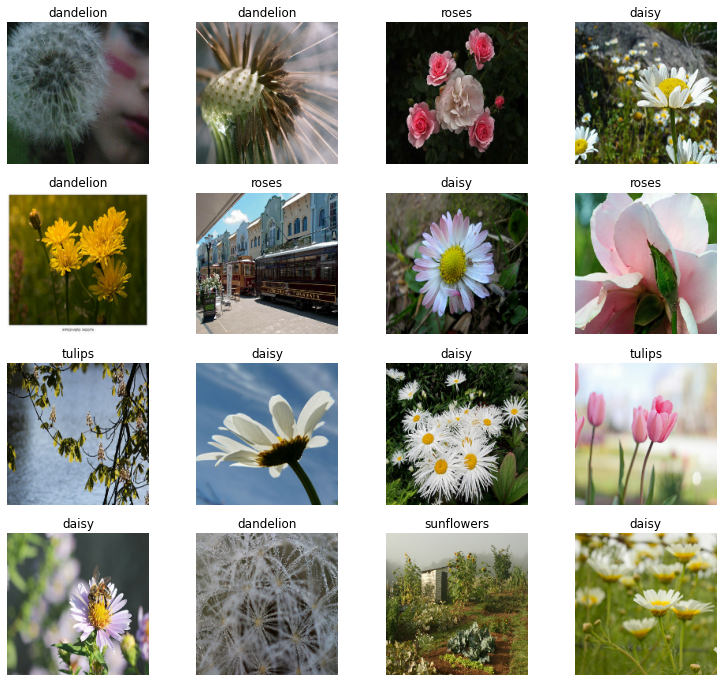

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 12))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_name[labels[i]])
    plt.axis("off")

In [18]:
for image_batch , label_batch in train_ds:
    print(image_batch.shape)
    print(label_batch.shape)
    break

(39, 180, 180, 3)
(39,)


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
normalization_layer = layers.Rescaling(1./255)

In [21]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99847496


3,4.Creating the Model & Add Layers (Convolution,MaxPooling,Flatten,Dense-(Hidden Layers),Output)



In [22]:
num_classes = len(class_name)
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width,3)),
    layers.Conv2D(16, 3 ,padding='same' , activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32, 3 ,padding='same' , activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64, 3 ,padding='same' , activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(128, 3 ,padding='same' , activation='relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dense(num_classes),
    
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

5,6.Compile The Model & Fit The Model

In [24]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [25]:
history = model.fit(train_ds,epochs=10, validation_data=test_ds)

Epoch 1/10
85/85 [==============================] - 115s 1s/step - loss: 1.2446 - accuracy: 0.4708 - val_loss: 0.9669 - val_accuracy: 0.6322
Epoch 2/10
85/85 [==============================] - 114s 1s/step - loss: 0.9579 - accuracy: 0.6252 - val_loss: 0.8444 - val_accuracy: 0.6812
Epoch 3/10
85/85 [==============================] - 113s 1s/step - loss: 0.7957 - accuracy: 0.6991 - val_loss: 0.8095 - val_accuracy: 0.6975
Epoch 4/10
85/85 [==============================] - 113s 1s/step - loss: 0.6870 - accuracy: 0.7414 - val_loss: 0.7933 - val_accuracy: 0.7057
Epoch 5/10
85/85 [==============================] - 112s 1s/step - loss: 0.5596 - accuracy: 0.7869 - val_loss: 0.8650 - val_accuracy: 0.6975
Epoch 6/10
85/85 [==============================] - 113s 1s/step - loss: 0.4418 - accuracy: 0.8295 - val_loss: 0.7364 - val_accuracy: 0.7248
Epoch 7/10
85/85 [==============================] - 113s 1s/step - loss: 0.3034 - accuracy: 0.8913 - val_loss: 0.8392 - val_accuracy: 0.7575
Epoch 8/10
85

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=10
epoch_range = range(epochs)

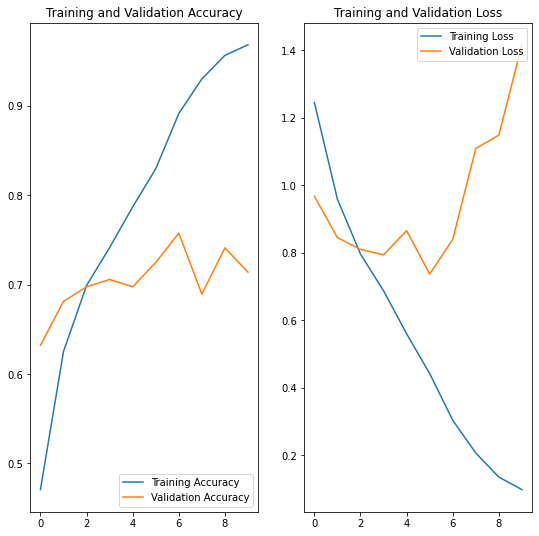

In [27]:
plt.figure(figsize=(9, 9))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, acc, label='Training Accuracy')
plt.plot(epoch_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss, label='Training Loss')
plt.plot(epoch_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

7.Save The Model

In [28]:
model.save('Flower.h5')

8.Test The Model

In [29]:
flower_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg'
flower_path = tf.keras.utils.get_file('Red_flower', origin=flower_url )

131072/117948 [=================================] - 0s 0us/step


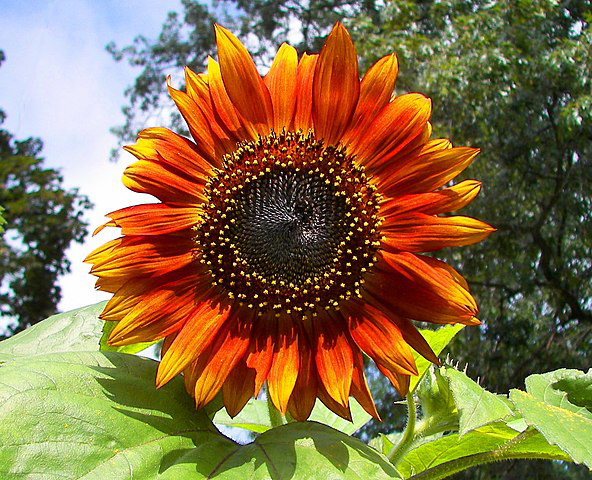

In [30]:
PIL.Image.open(flower_path)